In [1]:
import os
import pandas as pd
import numpy as np
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from anatomy.anatomy_api import AnatomyApi
import nrrd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import operator
import scipy
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import platform
if platform.system() == 'Windows':
    path = r'C:\Users\jenniferwh\Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_3'
    maskpath = r'C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress\2019 DMN\fMRI_masks'
elif platform.system() == 'Darwin':
    basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'

datapath = os.path.join(basepath, 'data_files')
savepath = os.path.join(basepath, '_new_figures', 'Figure_3')
maskpath = os.path.join(basepath, 'fMRI_masks')

In [3]:
dat = pd.read_csv(os.path.join(savepath, 'Ext Data Table 3_Corticocortical NPV matrices.csv'))

In [4]:
len(dat)

364

In [5]:
dat.rename(columns = {'Exp image series ID': 'image_series_id', 
                      'Rbp4 anchor image series ID': 'Rbp4_anchor_id',
                     'distance from anchor': 'distance', 
                      'Consensus Rbp4 anchor Source': 'Rbp4_source',
                     'Exp Source': 'source'}, 
           inplace = True)

In [6]:
dmn_dat = pd.read_csv(os.path.join(datapath, 
                                   'wt_cre_matched_layer_injections_DMN_and_core_projections_coefficients.csv'))
dmn_dat.rename(columns = {'id': 'image_series_id'}, inplace = True)
print(len(dmn_dat))

464


In [7]:
len([isid for isid in dmn_dat['image_series_id'] if 
     isid not in dat['image_series_id'].unique()]) #C57Bl/6 experiments

100

In [8]:
dat = dat.merge(dmn_dat[['image_series_id', 'injection dmn fraction',
                   'projection dmn fraction', 
                   'distance coefficient', 
                   'DMN coefficient',
                        'injection core fraction',
                        'projection core fraction',
                        'core distance coefficient',
                        'DMN core coefficient']], 
          on = 'image_series_id', how = 'left')

In [9]:
dat.rename(columns = {'DMN coefficient': 'dmn_coeff', 
                      'injection dmn fraction': 'inj_dmn_frac',
                      'projection dmn fraction': 'proj_dmn_frac',
                     'Exp Source': 'source'}, 
           inplace = True)

In [10]:
print(len(dat))

364


In [11]:
len(dat['Rbp4_anchor_id'].unique())

43

In [12]:
dat.loc[dat['Mouse Line'] == 'C57BL/6J / Emx1', 'layer'] = 'all'
dat.loc[dat['Mouse Line'].isin(['Cux2-IRES-Cre', 'Sepw1-Cre_NP39']), 'layer'] = '2/3'
dat.loc[dat['Mouse Line'].isin(['Nr5a1-Cre', 'Scnn1a-Tg3-Cre', 'Rorb-IRES2-Cre']), 'layer'] = '4'
dat.loc[dat['Mouse Line'].isin(['Tlx3-Cre_PL56', 'Rbp4-Cre_KL100']), 'layer'] = '5' #together
dat.loc[dat['Mouse Line'].isin(['Chrna2-Cre_OE25', 'Efr3a-Cre_NO108', 'Sim1-Cre_KJ18',
                               'A930038C07Rik-Tg1-Cre']), 'layer'] = '5 PT'
dat.loc[dat['Mouse Line'].isin(['Ntsr1-Cre_GN220', 'Syt6-Cre_KI148']), 'layer'] = '6'

In [13]:
# only include sources with at least one L2/3 and one L5 IT injection. This should be []
drop_sources = []
for source in dat['Rbp4_source'].unique():
    if len(dat[(dat['Rbp4_source'] == source) & 
                  (dat['layer'] == '2/3')]) == 0 or len(dat[(dat['Rbp4_source'] == source) & 
                  (dat['layer'] == '5')]) == 0:
        drop_sources.append(source)
drop_sources

[]

In [14]:
# should be []
dmn = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm',  'ORBvl', 'RSPagl', 'RSPd', 'RSPv', 
       'VISa', 'VISam', 'MOs', 'SSp-tr', 'SSp-ll']
out = ['AId', 'AIv', 'MOp', 'SSp-m', 'SSp-n', 'SSp-bfd', 'SSp-un', 'SSp-ul', 'SSs', 'FRP', 
       'VISC', 'GU', 'AIp', 'VISal', 'VISl', 'VISp-1', 'VISp-2', 'VISp-3', 'VISp-4', 
       'VISp-5', 'VISp-6', 'VISpl', 'VISli', 'VISpor', 'AUDd', 'AUDp', 'AUDv', 
       'AUDpo', 'TEa', 'PERI', 'ECT', 'VISrl', 'VISpm']
out_consolidated = ['AId', 'AIv', 'MOp', 'SSp-m', 'SSp-n', 'SSp-bfd', 'SSp-un', 'SSp-ul', 
                    'SSs', 'FRP', 
       'VISC', 'GU', 'AIp', 'VISal', 'VISl', 'VISp', 
      'VISpl', 'VISli', 'VISpor', 'AUDd', 'AUDp', 'AUDv', 
       'AUDpo', 'TEa', 'PERI', 'ECT', 'VISrl', 'VISpm']
plot_order = dmn+out
null_sources = [source for source in plot_order if 
                     len(dat[dat['Rbp4_source'] == source]) == 0]
plot_order = [source for source in plot_order if source not in null_sources]
print([source for source in dat['Rbp4_source'].unique() if source not in plot_order])

[]


In [15]:
cre_colors = ['k', 'c', 'c', 'm', 'm', 'm', 'lime', 'lightgray', 'b', 'b', 'b', 'b', 'yellow', 'yellow']

In [16]:
cre_order = ['C57BL/6J / Emx1', 'Cux2-IRES-Cre','Sepw1-Cre_NP39', 'Nr5a1-Cre', 'Scnn1a-Tg3-Cre',
            'Rorb-IRES2-Cre', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56', 'A930038C07Rik-Tg1-Cre', 'Chrna2-Cre_OE25',
            'Efr3a-Cre_NO108', 'Sim1-Cre_KJ18','Ntsr1-Cre_GN220', 'Syt6-Cre_KI148']

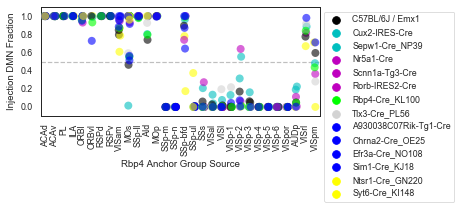

In [17]:
fig, ax = plt.subplots(figsize = (5, 2))
sns.stripplot('Rbp4_source', 'inj_dmn_frac', data = dat, s=8, 
              order = plot_order, hue = 'Mouse Line', hue_order = cre_order, 
              palette = cre_colors, alpha = 0.6)
plt.axhline(y=0.5, linestyle = '--', color = 'gray', alpha = 0.5)
plt.xticks(rotation = 90);
ax.set_ylabel('Injection DMN Fraction')
ax.set_xlabel('Rbp4 Anchor Group Source')
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = (cre_order, handles)
ax.legend(handles, labels, bbox_to_anchor = [1,1])

##### Revise text in manuscript to match what I actually do below: 
We eliminated the single MOs injection outside the DMN, the single SSp-bfd experiment outside the DMN, and the single VISp injection inside the DMN from our analysis. The following sources were eliminated because they did not contain both a L2/3 and an L5 experiment: ACAd, ORBm, ORBvl, RSPd, ILA, AUDd, VISli, RSPagl, VISpm. MOs and SSp-bfd were used only as in-DMN sources and VISp was used only as an out-DMN source.

In [18]:
dat[(dat['Rbp4_source'] == 'VISp-2') & 
                      (dat['inj_dmn_frac'] > 0.5)]['image_series_id'].values

array([272821309, 300929973])

In [19]:
dat[(dat['Rbp4_source'] == 'SSp-bfd') & 
                      (dat['inj_dmn_frac'] < 0.5)]['image_series_id'].values

array([178487444])

In [20]:
# make each source have only in or only out injections
drop_expts = [477037203, #single MOs injection outside the DMN
              141602484, #another MOs injection outside the DMN (barely: 46%)
             300929973, #one VISp injection inside the DMN
             272821309] #another VISp injection inside the DMN
drop_expts += list(dat[(dat['Rbp4_source'] == 'VISp-2') & 
                      (dat['inj_dmn_frac'] > 0.5)]['image_series_id'].values)
drop_expts += list(dat[(dat['Rbp4_source'] == 'SSp-bfd') & 
                      (dat['inj_dmn_frac'] < 0.5)]['image_series_id'].values)
drop_expts += list(dat[dat['Rbp4_source'] == 'VISpm']['image_series_id'].values)
plot_order.remove('VISpm')

In [21]:
dat = dat[~dat['image_series_id'].isin(drop_expts)]
print(len(dat))

351


In [22]:
# Most sources have experiments relatively evenly distributed across layers
# but MOs has a lot of L5 PT experiments.
dat[(dat['Rbp4_source'] == 'MOs') &
   (dat['layer'] == '5 PT')][['image_series_id',
                                  'Rbp4_anchor_id',
                                  'distance',
                                    'Mouse Line',
                                    'Manual PN class ',
                                  'layer']].sort_values(by=['layer','distance'])

,image_series_id,Rbp4_anchor_id,distance,Mouse Line,Manual PN class,layer
173,297854981,182793477,29.904390,Sim1-Cre_KJ18,PT,5 PT
231,267659565,120814821,158.456719,Efr3a-Cre_NO108,PT,5 PT
171,292174974,182793477,166.782782,Chrna2-Cre_OE25,PT,5 PT
193,297947641,168162771,194.971888,Sim1-Cre_KJ18,PT,5 PT
172,278258073,182793477,226.635413,Efr3a-Cre_NO108,PT,5 PT
230,267750528,120814821,258.653026,Chrna2-Cre_OE25,PT,5 PT
227,156394513,120814821,273.490389,A930038C07Rik-Tg1-Cre,IT PT,5 PT
167,176433237,182793477,286.369573,A930038C07Rik-Tg1-Cre,IT PT,5 PT
232,287807030,120814821,291.761938,Sim1-Cre_KJ18,PT,5 PT
191,287995889,168162771,351.998613,Efr3a-Cre_NO108,IT PT CT,5 PT


# Take the 4 experiments with the smallest distance (all were manually classified PT)
drop_5PT = [278258073, 267750528, 156394513, 176433237, 287807030, 287995889]
dat = dat[~dat['image_series_id'].isin(drop_5PT)]
print(len(dat))

In [23]:
dat[(dat['Rbp4_source'] == 'ACAv') & 
    (dat['layer'] == '6')][['layer', 
                            'Mouse Line',
                          'Manual PN class ', 
                          'Rbp4_source']]

,layer,Mouse Line,Manual PN class,Rbp4_source
71,6,Syt6-Cre_KI148,PT,ACAv
100,6,Ntsr1-Cre_GN220,CT,ACAv
105,6,Syt6-Cre_KI148,IT PT CT,ACAv


# Only keep CT experiments for L6
drop_L6 = dat[(dat['layer'] == '6') &
             (dat['Manual PN class '] != 'CT')]['image_series_id'].values
print(len(drop_L6))
dat = dat[~dat['image_series_id'].isin(drop_L6)]
print(len(dat))

# Only keep PT experiments for L5 PT
drop_L5 = dat[(dat['layer'] == '5 PT') &
             (~dat['Manual PN class '].isin(['PT', 'local']))]['image_series_id'].values
print(len(drop_L5))
dat = dat[~dat['image_series_id'].isin(drop_L5)]
print(len(dat))

In [24]:
dat[(dat['layer'] == '5') &
             (dat['Manual PN class '] == 'PT')]['image_series_id'].values

array([517072832])

In [25]:
# One Rbp4 experiment was classified as PT
drop_L5 = dat[(dat['layer'] == '5') &
             (dat['Manual PN class '] == 'PT')]['image_series_id'].values
print(len(drop_L5))
dat = dat[~dat['image_series_id'].isin(drop_L5)]
print(len(dat))

1
350


In [26]:
dat['layer'].unique()

array(['6', '2/3', '4', '5', 'all', '5 PT'], dtype=object)

In [27]:
dat[dat['Rbp4 Module'] == 'Medial']['source'].unique()

array(['VISam', 'VISa', 'RSPv', 'RSPd', 'VISpm'], dtype=object)

In [28]:
sources = []
Lall = []
L23 = []
L4 = []
L5 = []
L5PT = []
L6 = []
for source in dat['Rbp4_source'].unique():
    sources.append(source)
    Lall.append(len(dat[(dat['Rbp4_source'] == source) &
                       (dat['layer'] == 'all')]))
    L23.append(len(dat[(dat['Rbp4_source'] == source) &
                       (dat['layer'] == '2/3')]))
    L4.append(len(dat[(dat['Rbp4_source'] == source) &
                       (dat['layer'] == '4')]))
    L5.append(len(dat[(dat['Rbp4_source'] == source) &
                       (dat['layer'] == '5')]))
    L5PT.append(len(dat[(dat['Rbp4_source'] == source) &
                       (dat['layer'] == '5 PT')]))
    L6.append(len(dat[(dat['Rbp4_source'] == source) &
                       (dat['layer'] == '6')]))
expcount = pd.DataFrame({'all': Lall,
                        '2/3': L23,
                        '4': L4,
                        '5': L5,
                        '5 PT': L5PT,
                        '6': L6}, index = sources)

In [29]:
expcount.T.to_csv(os.path.join(savepath, 'experiment_count_layer_data_L5combined.csv'))

In [30]:
for layer in dat['layer'].unique():
    print(layer)
    print(dat[dat['layer'] == layer]['Manual PN class '].unique())

6
['CT' 'IT' 'PT' 'IT PT CT']
2/3
['IT']
4
['IT' 'local']
5
['IT' 'IT PT']
all
['IT PT CT']
5 PT
['PT' 'IT' 'local' 'IT PT' 'IT PT CT' 'CT']


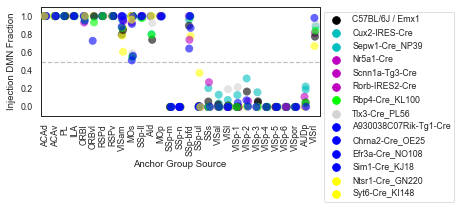

In [31]:
fig, ax = plt.subplots(figsize = (5, 2))
sns.stripplot('Rbp4_source', 'inj_dmn_frac', data = dat, s=8, 
              order = plot_order, hue = 'Mouse Line', hue_order = cre_order, 
              palette = cre_colors, alpha = 0.6)
plt.axhline(y=0.5, linestyle = '--', color = 'gray', alpha = 0.5)
plt.xticks(rotation = 90);
ax.set_ylabel('Injection DMN Fraction')
ax.set_xlabel('Anchor Group Source')
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = (cre_order, handles)
ax.legend(handles, labels, bbox_to_anchor = [1,1])
plt.savefig(os.path.join(savepath, 'Injection DMN Fraction per experiment.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [32]:
dat[dat['Rbp4_source'] == 'ACAd']['layer'].unique()

array(['6', '2/3', '5', '5 PT', 'all', '4'], dtype=object)

In [33]:
layer_plot_order = ['all', '2/3', '4', '5', '5 PT', '6']

In [34]:
layer_colors = ['k', 'c', 'm', 'gray', 'b', 'gold']

In [35]:
rs = []
pvals = []
for layer in dat['layer'].unique():
    print(layer)
    x=dat[dat['layer'] == layer]['inj_dmn_frac']
    y = dat[dat['layer'] == layer]['proj_dmn_frac']
    corr = scipy.stats.pearsonr(y, x)
    print(corr)
    rs.append(corr[0])
    pvals.append(corr[1])

6
(0.9813776956373559, 5.611587550254324e-44)
2/3
(0.959453623279162, 7.885441637155374e-26)
4
(0.9493297970404678, 3.1949282315794384e-22)
5
(0.9141349481182425, 9.725733429095664e-31)
all
(0.9519704422499229, 1.1955201141792254e-21)
5 PT
(0.9813742095769591, 8.33895384528991e-60)


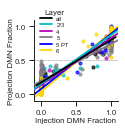

In [36]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
#dat['inj_percent_dmn'] = dat['injection dmn fraction'] * 100
#dat['percent_dmn'] = dat['projection dmn fraction'] * 100
zorder = 7
for ix, layer in enumerate(layer_plot_order):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='proj_dmn_frac', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':10,
                                  'alpha': 0.7})
ax.set_ylabel('Projection DMN Fraction', fontsize = 8)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 8)
legend = plt.legend(loc = 2, fontsize = 6, frameon = False,
          bbox_to_anchor = [0, 1.2], title = 'Layer', 
                    labelspacing = 0.2,
                   labels = layer_plot_order)
plt.setp(legend.get_title(),fontsize=8)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
plt.xticks([0, 0.5, 1], fontsize = 8)
plt.yticks([0, 0.5, 1], fontsize = 8)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_by_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [37]:
rs = []
pvals = []
for layer in dat['layer'].unique():
    print(layer)
    x=dat[dat['layer'] == layer]['inj_dmn_frac']
    y = dat[dat['layer'] == layer]['dmn_coeff']
    corr = scipy.stats.pearsonr(y, x)
    print(corr)
    rs.append(corr[0])
    pvals.append(corr[1])

6
(0.7097051249453579, 1.5197487585553e-10)
2/3
(0.5916088700782984, 1.4917353746470496e-05)
4
(0.48200805901724064, 0.0010645274696005245)
5
(0.5445056689048065, 3.6836493335116763e-07)
all
(0.6811196751345819, 9.523608666985629e-07)
5 PT
(0.45013693543001976, 1.957768129982559e-05)


In [38]:
print(dat['dmn_coeff'].min())
print(dat['dmn_coeff'].max())

-0.4227862658937338
0.3920405971066395


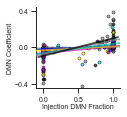

In [39]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
layer_colors = ['k', 'gray', 'c', 'gold', 'b', 'm']
for ix, layer in enumerate(['all', '5', '2/3', '5 PT', '6', '4']):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='dmn_coeff', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder,
                                 'alpha': 0.7},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                   'edgecolors': 'k',
                                  'linewidth':0.5})
ax.set_ylabel('DMN Coefficient', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
#ax.set_title('Ipsi and Contra')
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.45, 0.45])
plt.yticks([-0.4, 0, 0.4], fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'DMN_coefficient_by_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [40]:
print(dat['distance coefficient'].min())
print(dat['distance coefficient'].max())

-0.017539139968017838
-5.214455524599898e-05


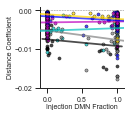

In [41]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
layer_colors = ['k', 'c', 'gray', 'gold', 'b', 'm']
for ix, layer in enumerate(['all', '2/3', '5', '6', '5 PT', '4']):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='distance coefficient', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder,
                                 'alpha': 0.7},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                  'edgecolors': 'k',
                                  'linewidth':0.5})
ax.set_ylabel('Distance Coefficient', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
#ax.set_title('Ipsi and Contra')
plt.setp(legend.get_title(),fontsize=7)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.02, 0.001])
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([-0.02, -0.01, 0], fontsize = 7)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'distance_coefficient_by_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [42]:
x=dat['inj_dmn_frac']
y = dat['proj_dmn_frac']
fit = sm.OLS(y, sm.add_constant(x, prepend=True)).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:          proj_dmn_frac   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     3297.
Date:                Fri, 08 May 2020   Prob (F-statistic):          1.39e-179
Time:                        01:18:42   Log-Likelihood:                 275.71
No. Observations:                 350   AIC:                            -547.4
Df Residuals:                     348   BIC:                            -539.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1285      0.008     15.902   

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


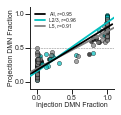

In [43]:
layer_colors = ['k', 'c', 'gray']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(['all', '2/3', '5']):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='proj_dmn_frac', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':18,
                                  'alpha': 0.7,
                                  'edgecolors': 'k',
                                  'linewidth':0.5})
ax.set_ylabel('Projection DMN Fraction', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
legend = plt.legend(loc = 2, fontsize = 5, frameon = False,
          bbox_to_anchor = [0, 1], 
                    labelspacing = 0.2,
                   labels = ['All, r=0.95', 'L2/3, r=0.96', 'L5, r=0.91'])
plt.setp(legend.get_title(),fontsize=8)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([0, 0.5, 1], fontsize = 7)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad=1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_by_layers_235_only.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

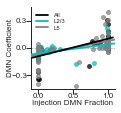

In [44]:
layer_colors = ['k', 'c', 'gray']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(['all', '2/3', '5']):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='dmn_coeff', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':15,
                                  'alpha': 0.7})
ax.set_ylabel('DMN Coefficient', fontsize = 8)
ax.yaxis.labelpad = -2
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 8)
legend = plt.legend(loc = 2, fontsize = 6, frameon = False,
          bbox_to_anchor = [0, 1], 
                    labelspacing = 0.2,
                   labels = ['All', 'L2/3', 'L5'])
plt.setp(legend.get_title(),fontsize=8)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.45, 0.45])
plt.yticks([-0.3, 0, 0.3], fontsize = 8)
plt.xticks([0, 0.5, 1], fontsize = 8)
ax.axhline(y = 0, xmin=0, xmax=11, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad = -1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'DMN_coefficient_by_layers_235_only.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

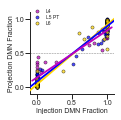

In [187]:
layer_colors = ['m', 'b', 'gold']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(['4', '5 PT', '6']):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='proj_dmn_frac', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                  'edgecolors': 'k',
                                  'linewidth':0.5})
ax.set_ylabel('Projection DMN Fraction', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['L4', 'L5 PT', 'L6']
order = [0,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc = 2, fontsize = 5, frameon = False,
          bbox_to_anchor = [-0.03, 1.1], labelspacing = 0.2)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([0, 0.5, 1], fontsize = 7)
ax.axhline(y = 0.5, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_by_layers_45PT6_only.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

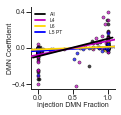

In [46]:
layer_colors = ['k', 'm', 'gold', 'b']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(['all', '5', '6', '5 PT']):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='dmn_coeff', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                  'edgecolors': 'k',
                                  'linewidth':0.5})
ax.set_ylabel('DMN Coefficient', fontsize = 7)
ax.yaxis.labelpad = -2
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
legend = plt.legend(loc = 2, fontsize = 5, frameon = False,
          bbox_to_anchor = [0, 1], 
                    labelspacing = 0.2,
                   labels = ['All', 'L4', 'L6', 'L5 PT'])
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.45, 0.45])
plt.yticks([-0.4, 0, 0.4], fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
ax.axhline(y = 0, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'DMN_coeff_by_layers_45PT6_only.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [47]:
dat.to_csv(os.path.join(savepath, 'curated_layer_data.csv'))

In [48]:
dat.loc[dat['inj_dmn_frac']>0.5, 'dmn_by_ol'] = 'in'
dat.loc[dat['inj_dmn_frac']<0.5, 'dmn_by_ol'] = 'out'
print(dat['dmn_by_ol'].unique())

['out' 'in']


In [49]:
pltdat = dat[['dmn_by_ol', 'layer', 'dmn_coeff']].melt(id_vars = ['dmn_by_ol', 'layer'],
                                                       value_vars = 'dmn_coeff',
                                                      var_name = 'coefficient')
pltdat2 = dat[['dmn_by_ol', 'layer', 'distance coefficient']].melt(id_vars = 
                                                                   ['dmn_by_ol', 'layer'],
                                                     value_vars = 'distance coefficient',
                                                     var_name = 'coefficient')
#pltdat2['dmn_by_ol'] = 'both'

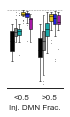

In [50]:
layer_plot_order = ['all', '5', '2/3', '6', '5 PT', '4']
layer_colors = [ 'k', 'gray',  'c', 'gold', 'b','m']
fig, ax = plt.subplots(figsize = (1,1.5))
sns.boxplot(x='dmn_by_ol', 
                y='value', 
            order = ['out', 'in'],
                data = pltdat2,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine(left = True)
#ax.set_ylim([-5,6])
#ax.set_yticks([-5.0, -2.5, 0.0, 2.5, 5.0])
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 8)
ax.set_yticklabels([None])
ax.set_xlabel("Inj. DMN Frac.", fontsize = 8)
ax.set_ylabel("")
ax.tick_params(left = False, pad=1)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'distance_coeff_boxplot_in-out_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [51]:
formula = 'value~C(layer)*dmn_by_ol' 
model = ols(formula, pltdat2).fit()
aov_table = anova_lm(model, typ=3)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
Intercept,0.0005,1.0,91.0988,0.0000
C(layer),0.0011,5.0,38.9481,0.0000
dmn_by_ol,0.0000,1.0,0.1197,0.7296
C(layer):dmn_by_ol,0.0001,5.0,2.8426,0.0157
Residual,0.0019,338.0,NaN,NaN


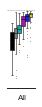

In [52]:
pltdat2['dmn_by_ol'] = 'both'
layer_plot_order = ['all', '5', '2/3', '4', '5 PT', '6']
layer_colors = ['k', 'gray',  'c', 'm', 'b', 'gold']
fig, ax = plt.subplots(figsize = (0.5,1.5))
sns.boxplot(x='dmn_by_ol', 
                y='value', 
            order = ['both'],
                data = pltdat2,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine(left = True)
ax.set_ylim([-0.02, 0.001])
ax.set_yticks([-0.02, -0.01, 0.0])
ax.set_xticklabels(['All'], fontsize = 8)
ax.set_yticklabels([None])
ax.set_xlabel("", fontsize = 8)
ax.set_ylabel("")
ax.tick_params(left = False, pad=1)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'distance_coeff_boxplot_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [53]:
formula = 'value~C(layer)' 
model = ols(formula, pltdat2).fit()
aov_table = anova_lm(model, typ=3)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
Intercept,0.0011,1.0,185.2262,0.0
C(layer),0.0018,5.0,61.5857,0.0
Residual,0.0020,344.0,NaN,NaN


In [54]:
stats.f_oneway(pltdat2[pltdat2['layer'] == '6']['value'],
               pltdat2[pltdat2['layer'] == '2/3']['value'],
               pltdat2[pltdat2['layer'] == '4']['value'],
               pltdat2[pltdat2['layer'] == '5']['value'],
               pltdat2[pltdat2['layer'] == 'all']['value'],
               pltdat2[pltdat2['layer'] == '5 PT']['value'])

F_onewayResult(statistic=61.58568553264476, pvalue=9.899497029659856e-46)

In [55]:
mc = MultiComparison(pltdat2['value'], 
                     pltdat2['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     4     0.0019  0.0035  0.0004  0.0034  True 
 2/3     5    -0.0012  0.0846 -0.0025  0.0001 False 
 2/3    5 PT   0.0029  0.001   0.0016  0.0041  True 
 2/3     6     0.0034  0.001   0.002   0.0047  True 
 2/3    all   -0.0033  0.001  -0.0048 -0.0018  True 
  4      5    -0.0031  0.001  -0.0045 -0.0018  True 
  4     5 PT   0.001   0.2983 -0.0004  0.0023 False 
  4      6     0.0015  0.0308  0.0001  0.0029  True 
  4     all   -0.0052  0.001  -0.0067 -0.0037  True 
  5     5 PT   0.0041  0.001   0.003   0.0052  True 
  5      6     0.0046  0.001   0.0034  0.0058  True 
  5     all   -0.0021  0.001  -0.0034 -0.0007  True 
 5 PT    6     0.0005  0.7795 -0.0007  0.0017 False 
 5 PT   all   -0.0061  0.001  -0.0075 -0.0048  True 
  6     all   -0.0067  0.001  -0.0081 -0.0052  True 
----------------------------------------------

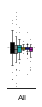

In [56]:
layer_plot_order = ['all', '5', '2/3', '6', '5 PT', '4']
layer_colors = [ 'k', 'gray',  'c', 'gold', 'b','m']
pltdat['dmn_by_ol'] = 'both'

fig, ax = plt.subplots(figsize = (0.5,1.5))
sns.boxplot(x='dmn_by_ol', 
                y='value', 
            order = ['both'],
                data = pltdat,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine(left = True)
ax.set_ylim([-0.45, 0.45])
plt.yticks([-0.4, 0, 0.4], fontsize = 8)
ax.set_xticklabels(['All'], fontsize = 8)
ax.set_yticklabels([None])
ax.set_xlabel("", fontsize = 8)
ax.set_ylabel("")
ax.tick_params(left = False, pad=1)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_coeffs_boxplot_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [57]:
formula = 'value~C(layer)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(layer),0.0268,5.0,0.6839,0.6359
Residual,2.6991,344.0,NaN,NaN


In [58]:
stats.f_oneway(pltdat[pltdat['layer'] == '6']['value'],
               pltdat[pltdat['layer'] == '2/3']['value'],
               pltdat[pltdat['layer'] == '4']['value'],
               pltdat[pltdat['layer'] == '5']['value'],
               pltdat[pltdat['layer'] == 'all']['value'],
               pltdat[pltdat['layer'] == '5 PT']['value'])

F_onewayResult(statistic=0.6839097664049298, pvalue=0.6359114290263846)

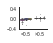

In [59]:
fig, ax = plt.subplots(figsize = (0.5,0.4))
sns.boxplot(x='dmn_by_ol', 
                y='dmn_coeff', 
            order = ['out', 'in'],
                data = dat[dat['layer'].isin(['4', '5 PT', '6'])],
                 hue = 'layer',
                 hue_order = ['4', '5 PT', '6'],
                 palette = ['m', 'b', 'gold'],
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine()
ax.set_ylim([-0.45, 0.45])
plt.yticks([-0.4, 0, 0.4], fontsize = 5)
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(bottom=False, left = False, pad=-3)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_coeff_boxplot_by_inj_frac_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [60]:
layer = '2/3'
x=dat[dat['layer'] == layer]['inj_dmn_frac']
y = dat[dat['layer'] == layer]['proj_dmn_frac']
fit = sm.OLS(y, sm.add_constant(x, prepend=True)).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:          proj_dmn_frac   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     509.8
Date:                Fri, 08 May 2020   Prob (F-statistic):           7.89e-26
Time:                        01:18:47   Log-Likelihood:                 42.272
No. Observations:                  46   AIC:                            -80.54
Df Residuals:                      44   BIC:                            -76.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1547      0.021      7.253   

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [61]:
np.std(rs)

0.09560086011389148

In [62]:
rs = []
for layer in dat['layer'].unique():
    print(layer)
    x=dat[dat['layer'] == layer]['inj_dmn_frac']
    y = dat[dat['layer'] == layer]['dmn_coeff']
    corr = scipy.stats.pearsonr(y, x)
    print(corr)
    rs.append(corr[0])

6
(0.7097051249453579, 1.5197487585553e-10)
2/3
(0.5916088700782984, 1.4917353746470496e-05)
4
(0.48200805901724064, 0.0010645274696005245)
5
(0.5445056689048065, 3.6836493335116763e-07)
all
(0.6811196751345819, 9.523608666985629e-07)
5 PT
(0.45013693543001976, 1.957768129982559e-05)


In [63]:
rs = []
for layer in dat['layer'].unique():
    print(layer)
    x=dat[dat['layer'] == layer]['inj_dmn_frac']
    y = dat[dat['layer'] == layer]['distance coefficient']
    fit = sm.OLS(y, sm.add_constant(x, prepend=True)).fit()
    print(fit.rsquared)
    rs.append(fit.rsquared)

6
0.15217470565487146
2/3
0.018206841425159603
4
0.0030410888957730364
5
0.13657115001223352
all
0.05319810881988196
5 PT
0.05503505458730196


In [64]:
print(len(dat))
print(len(dat['Rbp4_source'].unique()))

350
29


In [65]:
[source for source in dat['source'].unique() if source not in dmn and 
 source not in out_consolidated]

[]

In [66]:
data = dat[['dmn_by_ol', 'layer', 'dmn_coeff']]
table = sm.stats.Table.from_data(data)
print(table.table_orig)

layer      2/3   4   5  5 PT   6  all
dmn_by_ol                            
in          22  16  31    44  28   18
out         24  27  45    39  33   23


In [67]:
dat.loc[dat['source'].isin(dmn), 'dmn_by_structure'] = 'in'
dat.loc[dat['source'].isin(out_consolidated), 'dmn_by_structure'] = 'out'
print(dat['dmn_by_structure'].unique())

['out' 'in']


In [68]:
data = dat[['dmn_by_structure', 'layer', 'dmn_coeff']]
table = sm.stats.Table.from_data(data)
print(table.table_orig)

layer             2/3   4   5  5 PT   6  all
dmn_by_structure                            
in                 18  10  26    35  25   14
out                28  33  50    48  36   27


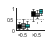

In [69]:
fig, ax = plt.subplots(figsize = (0.5,0.4))
sns.boxplot(x='dmn_by_ol', 
                y='proj_dmn_frac', 
            order = ['out', 'in'],
                data = dat[dat['layer'].isin(['all', '2/3', '5'])],
                 hue = 'layer',
                 hue_order = ['all', '5', '2/3'],
                 palette = ['k', 'gray', 'c'],
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine()
ax.set_ylim([0,1])
ax.set_yticks([0, 0.5, 1])
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 5)
ax.set_yticklabels([0, 0.5, 1], fontsize = 5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(bottom=False, left = False, pad=-3)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_boxplot_by_inj_frac_in-out.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

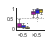

In [70]:
fig, ax = plt.subplots(figsize = (0.5,0.4))
sns.boxplot(x='dmn_by_ol', 
                y='proj_dmn_frac', 
            order = ['out', 'in'],
                data = dat[dat['layer'].isin(['4', '5 PT', '6'])],
                 hue = 'layer',
                 hue_order = ['4', '5 PT', '6'],
                 palette = ['m', 'b', 'gold'],
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine()
ax.set_ylim([-0.1,1])
ax.set_yticks([0, 0.5, 1])
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 5)
ax.set_yticklabels([0, 0.5, 1], fontsize = 5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(bottom=False, left = False, pad=-3)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_boxplot_by_inj_frac_L45PT6.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [71]:
outdat = dat.groupby(['dmn_by_structure', 'layer']).count().reset_index()[['dmn_by_structure',
                                                                        'layer',
                                                                         'image_series_id']].T
outdat.to_csv(os.path.join(savepath, 'counts_by_in_out.csv'), index = False)

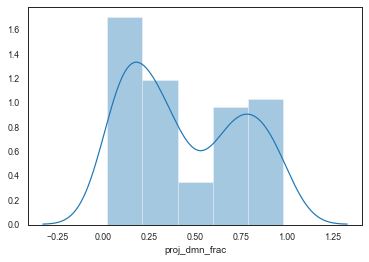

In [72]:
sns.distplot(dat[dat['layer'].isin(['all', '2/3', '5'])]['proj_dmn_frac'])

In [73]:
formula = 'proj_dmn_frac~dmn_by_ol*C(layer)' 
model = ols(formula, dat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf

In [74]:
aov_table.round(4)

,sum_sq,df,F,PR(>F)
dmn_by_ol,37.5800,1.0,2549.7642,0.0000
C(layer),0.1345,5.0,1.8251,0.1073
dmn_by_ol:C(layer),1.2651,5.0,17.1668,0.0000
Residual,4.9817,338.0,NaN,NaN


In [75]:
mc = MultiComparison(dat[(dat['dmn_by_ol'] == 'in')]['proj_dmn_frac'], 
                     dat[(dat['dmn_by_ol'] == 'in')]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     4    -0.0389   0.9   -0.1717  0.094  False 
 2/3     5    -0.1306  0.013  -0.2434 -0.0179  True 
 2/3    5 PT   0.0142   0.9   -0.0914  0.1198 False 
 2/3     6     0.0413   0.9   -0.0739  0.1565 False 
 2/3    all   -0.0759  0.5273 -0.2044  0.0527 False 
  4      5    -0.0918  0.2787 -0.2163  0.0327 False 
  4     5 PT   0.053   0.7602 -0.0651  0.1711 False 
  4      6     0.0801  0.4547 -0.0466  0.2069 False 
  4     all    -0.037   0.9    -0.176  0.102  False 
  5     5 PT   0.1448  0.001    0.05   0.2396  True 
  5      6     0.1719  0.001   0.0665  0.2774  True 
  5     all    0.0548  0.7467 -0.0651  0.1746 False 
 5 PT    6     0.0271   0.9   -0.0706  0.1249 False 
 5 PT   all    -0.09   0.2021 -0.2032  0.0231 False 
  6     all   -0.1171  0.0686 -0.2393  0.0051 False 
----------------------------------------------

In [76]:
mc = MultiComparison(dat[(dat['dmn_by_ol'] == 'out')]['proj_dmn_frac'], 
                     dat[(dat['dmn_by_ol'] == 'out')]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     4    -0.0533  0.4452 -0.1369  0.0302 False 
 2/3     5     0.0014   0.9   -0.0738  0.0767 False 
 2/3    5 PT  -0.1184  0.001  -0.1956 -0.0412  True 
 2/3     6    -0.1644  0.001  -0.2443 -0.0845  True 
 2/3    all   -0.0132   0.9   -0.1001  0.0737 False 
  4      5     0.0548  0.2537 -0.0177  0.1273 False 
  4     5 PT  -0.0651  0.1251 -0.1396  0.0095 False 
  4      6    -0.1111  0.001  -0.1883 -0.0338  True 
  4     all    0.0402  0.7184 -0.0443  0.1246 False 
  5     5 PT  -0.1198  0.001   -0.185 -0.0547  True 
  5      6    -0.1658  0.001  -0.2341 -0.0976  True 
  5     all   -0.0146   0.9   -0.0909  0.0617 False 
 5 PT    6     -0.046  0.4188 -0.1164  0.0244 False 
 5 PT   all    0.1052  0.0021  0.0269  0.1835  True 
  6     all    0.1512  0.001   0.0704  0.2321  True 
----------------------------------------------

In [77]:
formula = 'proj_dmn_frac~inj_dmn_frac*C(layer)' 
model = ols(formula, dat[dat['layer'].isin(['all', '2/3', '5'])]).fit()
aov_table = anova_lm(model, typ=1) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf

In [78]:
aov_table.round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(layer),2.0,0.2682,0.1341,12.0761,0.0000
inj_dmn_frac,1.0,13.1033,13.1033,1180.1095,0.0000
inj_dmn_frac:C(layer),2.0,0.1838,0.0919,8.2779,0.0004
Residual,157.0,1.7432,0.0111,NaN,NaN


In [79]:
stats.shapiro(model.resid)

(0.9857468008995056, 0.09435700625181198)

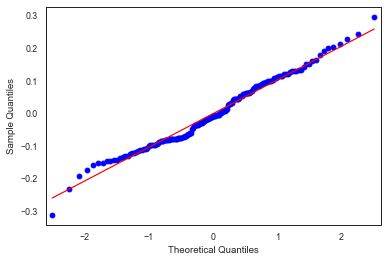

In [80]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [81]:
mc = MultiComparison(dat[(dat['layer'].isin(['all', '2/3', '5']))]['proj_dmn_frac'], 
                     dat[(dat['layer'].isin(['all', '2/3', '5']))]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 2/3     5    -0.0966  0.2135 -0.2321 0.0389 False 
 2/3    all   -0.0653  0.5771 -0.2211 0.0904 False 
  5     all    0.0313  0.8433 -0.1092 0.1718 False 
---------------------------------------------------


In [82]:
mc = MultiComparison(dat[(dat['layer'].isin(['2/3', '5']))]['inj_dmn_frac'], 
                     dat[(dat['layer'].isin(['2/3', '5']))]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 2/3     5    -0.0995  0.2561 -0.2723 0.0732 False 
---------------------------------------------------


In [83]:
mc = MultiComparison(dat[(dat['dmn_by_structure'] == 'in') &
                         (dat['layer'].isin(['2/3', '5']))]['proj_dmn_frac'], 
                     dat[(dat['dmn_by_structure'] == 'in') &
                         (dat['layer'].isin(['2/3', '5']))]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     5    -0.1894  0.0026 -0.3087 -0.0702  True 
----------------------------------------------------


mc = MultiComparison(dat[(dat['dmn_by_structure'] == 'out') &
                         (dat['layer'].isin(['2/3', '5']))]['percent_dmn'], 
                     dat[(dat['dmn_by_structure'] == 'out') &
                         (dat['layer'].isin(['2/3', '5']))]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results) #I'm not sure why this doesn't work but the code above for in-DMN structures does work. I'm sure there is not a significant difference, though

In [84]:
import imageio
imb = imageio.imread(os.path.join(savepath, 'DMN_cortical_projection_boundaries.png'))

In [85]:
top_coords = pd.read_csv(os.path.join(basepath, 
                                       'data_files',
                                       'cortical_flatmap_coordinates.csv'))
top_coords.rename(columns = {'id': 'image_series_id'}, inplace = True)

In [86]:
dat = dat.merge(top_coords[['image_series_id', 
                                      'top_x', 
                                       'top_y']], 
                on = 'image_series_id',
               how = 'left')

In [87]:
len(dat[dat['top_x'].isnull()])

0

In [88]:
dat[dat['top_x'].isnull()]['image_series_id'].values

array([], dtype=int64)

In [89]:
Rbp4_groups = pd.DataFrame({'image_series_id': dat['Rbp4_anchor_id'].unique()})
Rbp4_groups = Rbp4_groups.merge(top_coords[['image_series_id', 
                                      'top_x', 
                                       'top_y']], 
                                on = 'image_series_id',
                               how = 'left')

In [90]:
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
wt_expts = mcc.get_experiments(cre=False, injection_structure_ids = [isocortex['id']])
cre_expts = mcc.get_experiments(cre=['Syt6-Cre_KI148', 'Cux2-IRES-Cre', 'Scnn1a-Tg3-Cre',
       'Tlx3-Cre_PL56', 'Emx1-IRES-Cre', 'Rbp4-Cre_KL100',
       'A930038C07Rik-Tg1-Cre', 'Ntsr1-Cre_GN220', 'Nr5a1-Cre',
       'Rorb-IRES2-Cre', 'Efr3a-Cre_NO108', 'Chrna2-Cre_OE25',
       'Sepw1-Cre_NP39', 'Sim1-Cre_KJ18'],
                                injection_structure_ids = [isocortex['id']])
experiments = wt_expts + cre_expts
experiments = pd.DataFrame(experiments)
experiments.rename(columns = {'id': 'image_series_id'}, inplace = True)

In [91]:
len(Rbp4_groups[Rbp4_groups['top_x'].isnull()])

0

In [92]:
dat = dat.merge(experiments[['image_series_id', 'injection_volume']], 
                on = 'image_series_id', how = 'left')
Rbp4_groups = Rbp4_groups.merge(experiments[['image_series_id', 'injection_volume']], 
                on = 'image_series_id', how = 'left')

In [93]:
Rbp4_groups[Rbp4_groups['image_series_id'].isin([159753308, 524667618])] #VISam group

,image_series_id,top_x,top_y,injection_volume
2,524667618,383.0,749.0,0.115642
6,159753308,394.0,785.0,0.124457


In [94]:
len(Rbp4_groups)

42

In [95]:
Rbp4_groups['flipped_x'] = 570+(570 - Rbp4_groups['top_x'])
Rbp4_groups.loc[Rbp4_groups['top_x'] > 570, 'flipped_x'] = Rbp4_groups.loc[
    Rbp4_groups['top_x'] > 570, 'top_x']
dat['flipped_x'] = 570+(570 - dat['top_x'])
dat.loc[dat['top_x'] > 570, 'flipped_x'] = dat.loc[dat['top_x'] > 570, 'top_x']

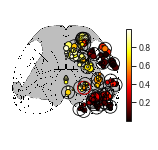

In [96]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(Rbp4_groups['flipped_x'],
                Rbp4_groups['top_y'],
                 marker = 'o',
                 c = 'none',
                edgecolor = 'k',
                s = 170)
cax = ax.scatter(Rbp4_groups[Rbp4_groups['image_series_id'] == 159753308]['flipped_x'],
                Rbp4_groups[Rbp4_groups['image_series_id'] == 159753308]['top_y'],
                 marker = 'o',
                 c = 'none',
                edgecolor = 'r',
                s = 170)
cax = ax.scatter(dat.flipped_x,
           dat.top_y,
           c = dat['proj_dmn_frac'],
           edgecolor = 'k',
           s = dat.injection_volume.values*100,
           cmap = 'hot')
cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, 
                    pad=0.01)

cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)
plt.savefig(os.path.join(savepath, 'cre_injections_on_DMN_ctx_DMN_fraction.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [97]:
print(dat['dmn_coeff'].min())
print(dat['dmn_coeff'].max())

-0.4227862658937338
0.3920405971066395


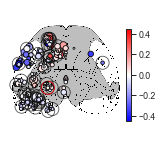

In [98]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(Rbp4_groups['top_x'],
                Rbp4_groups['top_y'],
                 marker = 'o',
                 c = 'none',
                edgecolor = 'k',
                 alpha = 0.7,
                s = 170)
cax = ax.scatter(Rbp4_groups[Rbp4_groups['image_series_id'] == 159753308]['top_x'],
                Rbp4_groups[Rbp4_groups['image_series_id'] == 159753308]['top_y'],
                 marker = 'o',
                 c = 'none',
                edgecolor = 'r',
                s = 170)
cax = ax.scatter(dat.top_x,
           dat.top_y,
           c = dat['dmn_coeff'],
           edgecolor = 'k',
           s = dat.injection_volume.values*100,
           cmap = 'bwr',
                 vmax = 0.45,
                 vmin = -0.45)
cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, 
                    pad=0.01)

cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)
plt.savefig(os.path.join(savepath, 'cre_injections_on_DMN_ctx_DMN_coeff.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [99]:
dat['layer'].unique()

array(['6', '2/3', '4', '5', 'all', '5 PT'], dtype=object)

In [100]:
Rbp4_groups[Rbp4_groups['image_series_id'].isin([159753308, 524667618])]['flipped_x']

2    757.0
6    746.0
Name: flipped_x, dtype: float64

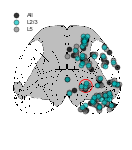

In [101]:
dat.sort_values(by='injection_volume', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(Rbp4_groups[
    Rbp4_groups['image_series_id'].isin([159753308, 524667618])]['flipped_x'].mean(),
                Rbp4_groups[
                    Rbp4_groups['image_series_id'].isin([159753308, 524667618])]['top_y'].mean(),
                 marker = 'o',
                 c = 'none',
                edgecolor = 'r',
                s = 170)
cax = ax.scatter(dat[dat['layer'] == '5'].flipped_x,
           dat[dat['layer'] == '5'].top_y,
           c = 'gray',
           edgecolor = 'k',
                 linewidth = 0.5,
                 alpha = 0.7,
                 zorder = 2,
           s = 25,
                label = 'L5')
cax = ax.scatter(dat[dat['layer'] == '2/3'].flipped_x,
           dat[dat['layer'] == '2/3'].top_y,
           c = 'c',
           edgecolor = 'k',
                 linewidth = 0.5,
                 alpha = 0.7,
                 zorder = 3,
           s = 25,
                label = 'L2/3')
cax = ax.scatter(dat[dat['layer'] == 'all'].flipped_x,
           dat[dat['layer'] == 'all'].top_y,
           c = 'k',
           edgecolor = 'k',
                 linewidth = 0.5,
                 alpha = 0.8,
                 zorder = 1,
           s = 25,
                label = 'All')
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles[::-1], labels[::-1],
                    loc = 1, fontsize = 6, frameon = False,
          bbox_to_anchor = [0.3, 1], 
                    labelspacing = 0.3)
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)
plt.savefig(os.path.join(savepath, 'cre_injections_on_DMN_ctx_L235.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [102]:
layer_colors

['k', 'gray', 'c', 'gold', 'b', 'm']

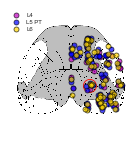

In [103]:
dat.sort_values(by='injection_volume', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(Rbp4_groups[
    Rbp4_groups['image_series_id'].isin([159753308, 524667618])]['flipped_x'].mean(),
                Rbp4_groups[
                    Rbp4_groups['image_series_id'].isin([159753308, 524667618])]['top_y'].mean(),
                 marker = 'o',
                 c = 'none',
                edgecolor = 'r',
                s = 170)
cax = ax.scatter(dat[dat['layer'] == '4'].flipped_x,
           dat[dat['layer'] == '4'].top_y,
           c = 'm',
           edgecolor = 'k',
                 alpha = 0.7,
           s = 25,
                label = 'L4')
cax = ax.scatter(dat[dat['layer'] == '5 PT'].flipped_x,
           dat[dat['layer'] == '5 PT'].top_y,
           c = 'b',
           edgecolor = 'k',
                 alpha = 0.7,
           s = 25,
                label = 'L5 PT')
cax = ax.scatter(dat[dat['layer'] == '6'].flipped_x,
           dat[dat['layer'] == '6'].top_y,
           c = 'gold',
           edgecolor = 'k',
                 alpha = 0.7,
           s = 25,
                label = 'L6')
legend = plt.legend(loc = 1, fontsize = 6, frameon = False,
          bbox_to_anchor = [0.3, 1], 
                    labelspacing = 0.3)
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)
plt.savefig(os.path.join(savepath, 'cre_injections_on_DMN_ctx_L45PT6.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [104]:
dat['consolidated_layer'] = dat['layer']
dat.loc[dat['layer'].isin(['5 IT PT', '5 IT']), 'consolidated_layer'] = '5'
dat['consolidated_source'] = dat['Rbp4_source']
dat.loc[dat['Rbp4_source'].isin(['VISp-1', 'VISp-2', 'VISp-3', 'VISp-4', 'VISp-5',
                           'VISp-6']),
       'consolidated_source'] = 'VISp'

In [105]:
consolidated_plot_order = ['ACAd','ACAv','PL','ILA','ORBl', 'ORBvl',
                           'RSPd','RSPv', 'VISam', 'MOs',
                           'SSp-ll','MOp', 'SSp-m','SSp-n',
                           'SSp-bfd','SSp-ul', 'SSs','AId', 'VISal','VISl', 
                           'VISp','VISpor','VISrl','AUDp']

In [106]:
[source for source in dat['consolidated_source'].unique() if source not in consolidated_plot_order]

[]

In [107]:
layer_subset_order = ['2/3', '5']
layer_subset_colors = ['c', 'gray']

In [108]:
dat['layer'].unique()

array(['all', '5', '2/3', '5 PT', '4', '6'], dtype=object)

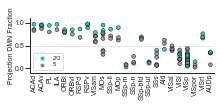

In [109]:
fig, ax = plt.subplots(figsize = (3.3, 1))
sns.stripplot('consolidated_source', 'proj_dmn_frac', 
            data = dat[dat['layer'].isin(['2/3', '5'])], 
            hue = 'consolidated_layer',
            order = consolidated_plot_order,
            hue_order = layer_subset_order,
           palette = layer_subset_colors,
             alpha = 0.8,
             jitter=False,
              edgecolor = 'k',
              linewidth = 0.5,
            s=4)
ax.axhline(y = 50, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.set_ylim([-0.1,1.1])
ax.set_xlabel(None)
ax.set_ylabel('Projection DMN Fraction', fontsize = 7, labelpad = 1)
ax.tick_params(top = False, right = False, bottom = False, left = True)
plt.xticks(rotation = 90, fontsize = 7)
ax.tick_params(axis = 'y', pad=1)
ax.tick_params(axis = 'x', pad = -3)
legend = plt.legend(fontsize = 6, 
          loc = 3,
            labelspacing = 0.2)
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [10]
sns.despine()
fig.canvas.draw()
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7)
plt.axhline(y=0.5, linestyle = '--', color = 'gray', alpha = 0.5, 
            linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'DMN_proj_percent_by_layer_in_sources.pdf'), bbox_inches='tight', 
            pad_inches=0.3, 
            format='pdf', transparent = True, dpi=300)

In [110]:
dat[dat['dmn_by_structure'] == 'in']['source'].unique()

array(['MOs', 'ORBvl', 'ILA', 'SSp-ll', 'ORBl', 'PL', 'ORBm', 'ACAv',
       'RSPv', 'ACAd', 'VISam', 'RSPd', 'RSPagl', 'VISa'], dtype=object)

In [111]:
dat[dat['dmn_by_structure'] == 'out']['source'].unique()

array(['VISp', 'SSp-bfd', 'SSs', 'AId', 'AUDd', 'SSp-n', 'SSp-ul', 'MOp',
       'SSp-m', 'VISli', 'AUDp', 'VISal', 'VISl', 'VISrl', 'VISpor',
       'SSp-un', 'VISpm'], dtype=object)

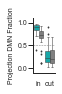

In [112]:
fig, ax = plt.subplots(1, figsize = (0.4, 1))
sns.boxplot('dmn_by_structure', 'proj_dmn_frac',
              data = dat[dat['layer'].isin(['2/3', '5'])], 
              order = ['in', 'out'], linewidth = 0.5,
              ax = ax, hue = 'layer', palette = layer_subset_colors, 
              hue_order = layer_subset_order, fliersize = 1)
ax.set_ylim([-0.1,1.1])
plt.xticks([0, 1], fontsize = 7)
plt.yticks([0, 0.5, 1], fontsize = 7)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.set_ylabel('Projection DMN Fraction', fontsize = 7)
ax.tick_params(axis = 'y', pad=1)
ax.set_xlabel('')
ax.tick_params(top = False, right = False, left = True,
               bottom = False)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'Cre_DMN_proj_boxplot_in-out.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

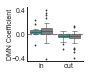

In [113]:
fig, ax = plt.subplots(1, figsize = (1, 1))
sns.boxplot('dmn_by_structure', 'dmn_coeff',
              data = dat[dat['consolidated_layer'].isin(['2/3', '5'])], 
              order = ['in', 'out'], linewidth = 0.5,
              ax = ax, hue = 'consolidated_layer', palette = layer_subset_colors, 
              hue_order = layer_subset_order, fliersize = 1)
ax.axhline(y = 0, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.set_ylim([-0.45, 0.45])
plt.yticks([-0.4, 0, 0.4], fontsize = 7)
plt.xticks([0, 1], fontsize = 7)
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_xlabel("")
ax.set_ylabel("DMN Coefficient", fontsize = 7)
ax.yaxis.labelpad = -2
ax.tick_params(top = False, right = False, 
               bottom = False, left = False, pad = -3)
ax.legend_.remove()
ax.axhline(y=0, xmin=0, xmax=100, color = 'grey', linestyle = 'dashed', zorder = -1)
plt.savefig(os.path.join(savepath, 'Cre_DMN_coeff_boxplot_in-out.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [114]:
mcd = {'red': '#ff0000', 'orange': '#f9922b', 'yellow': '#ffff66', 'light_blue': '#90bff9',
      'dark_blue': '#5252a9', 'purple': '#7c429b'}
mod_order = ['PFC', 'Medial', 'Somatomotor', 'Lateral', 'Visual', 'Auditory']
colors = [mcd['red'], mcd['dark_blue'], 
          mcd['orange'], mcd['yellow'],
          mcd['light_blue'], mcd['purple']]

In [115]:
pltdat = dat[dat['layer'].isin(['2/3', '5'])]

In [116]:
mod_order = ['PFC', 'Medial', 'Somatomotor', 'Lateral', 'Visual', 'Auditory']

In [117]:
pltdat[pltdat['Rbp4 Module'] == 'Medial']['source'].unique()

array(['RSPv', 'VISam', 'RSPd'], dtype=object)

In [118]:
pltdat[pltdat['source'] == 'RSPagl']

,image_series_id,Rbp4_anchor_id,distance,Rbp4_source,Rbp4 Module,Mouse Line,source,Exp Module,Selected anchor for Figures?,Manual PN class,...,DMN core coefficient,layer,dmn_by_ol,dmn_by_structure,top_x,top_y,injection_volume,flipped_x,consolidated_layer,consolidated_source
28,168164230,168164230,0.000000,VISp-6,Visual,Rbp4-Cre_KL100,RSPagl,Medial,N,IT PT,...,-0.072702,5,out,in,438.0,992.0,0.104929,702.0,5,VISp
26,614094233,168164230,64.599138,VISp-6,Visual,Tlx3-Cre_PL56,RSPagl,Medial,N,IT,...,-0.032094,5,out,in,443.0,988.0,0.015257,697.0,5,VISp


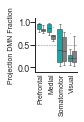

In [119]:
fig, ax = plt.subplots(1, figsize = (0.75, 1))
sns.boxplot('Rbp4 Module', 'proj_dmn_frac', data = pltdat, 
            order = ['PFC', 'Medial', 'Somatomotor', 'Visual'], ax = ax, 
            hue = 'layer', hue_order = ['2/3', '5'],
            palette = ['c', 'gray'], fliersize = 0.1, linewidth = 0.5)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
sns.despine()
ax.tick_params(top = False, right = False, bottom = False, left = True)
ax.set_ylim([-0.1,1.1])
plt.xticks(rotation = 90, fontsize = 7)
ax.set_xticklabels(['Prefrontal', 'Medial', 'Somatomotor', 'Visual'], fontsize=7)
plt.yticks([0, 0.5, 1])
ax.set_ylabel('Projection DMN Fraction', fontsize = 7)
ax.tick_params(axis = 'y', pad=1)
ax.tick_params(axis = 'x', pad = -4)
ax.set_xlabel(None)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_fraction_by_module_and_layer_boxplot_horizontal.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

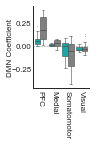

In [120]:
fig, ax = plt.subplots(1, figsize = (1, 1.5))
sns.boxplot('Rbp4 Module', 'dmn_coeff', data = pltdat, 
            order = ['PFC', 'Medial', 'Somatomotor', 'Visual'], ax = ax, 
            hue = 'consolidated_layer', hue_order = ['2/3', '5'],
            palette = ['c', 'gray'], fliersize = 0.1, linewidth = 0.5)
ax.axhline(y = 0, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False)
plt.yticks(fontsize = 8)
plt.xticks(rotation = -90, fontsize = 8)
ax.set_xlabel("")
ax.set_ylabel("DMN Coefficient", fontsize = 8)
ax.yaxis.labelpad = -2
ax.tick_params(top = False, right = False, bottom = False, left = False, pad = -3)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_coeff_by_module_and_layer_boxplot_horizontal.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [121]:
pltdat['layer'].unique()

array(['5', '2/3'], dtype=object)

In [122]:
pltdat.rename(columns = {'Rbp4 Module': 'module'}, inplace = True)
formula = 'proj_dmn_frac~C(layer)*C(module)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=1)

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [123]:
aov_table.round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(layer),1.0,0.2674,0.2674,6.4015,0.0128
C(module),5.0,6.4946,1.2989,31.1006,0.0000
C(layer):C(module),5.0,0.1313,0.0263,0.6287,0.6782
Residual,110.0,4.5942,0.0418,NaN,NaN


In [124]:
stats.shapiro(model.resid)

(0.9805707335472107, 0.07571496814489365)

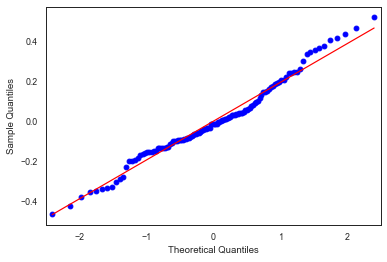

In [125]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [126]:
mc = MultiComparison(pltdat['proj_dmn_frac'], 
                     pltdat['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 2/3     5    -0.0966  0.0934 -0.2097 0.0165 False 
---------------------------------------------------


In [127]:
mc = MultiComparison(pltdat['proj_dmn_frac'], 
                     pltdat['module'])
mc_results = mc.tukeyhsd()
print(mc_results)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
  Auditory    Lateral    0.2519  0.5725 -0.1973  0.7012 False 
  Auditory     Medial    0.4931  0.001   0.1496  0.8365  True 
  Auditory      PFC      0.5974  0.001   0.2722  0.9225  True 
  Auditory  Somatomotor  0.1609  0.6452 -0.1505  0.4724 False 
  Auditory     Visual   -0.0307   0.9   -0.3357  0.2743 False 
  Lateral      Medial    0.2411  0.4563  -0.142  0.6243 False 
  Lateral       PFC      0.3454  0.0775 -0.0214  0.7122 False 
  Lateral   Somatomotor  -0.091   0.9   -0.4457  0.2637 False 
  Lateral      Visual   -0.2826  0.1843 -0.6317  0.0665 False 
   Medial       PFC      0.1043  0.7336 -0.1208  0.3294 False 
   Medial   Somatomotor -0.3321  0.001  -0.5369 -0.1273  True 
   Medial      Visual   -0.5237  0.001  -0.7186 -0.3288  True 
    PFC     Somatomotor -0.4364  0.001  -0.6088 -0.2641

In [128]:
for module in pltdat['module'].unique():
    if module != 'Lateral': #not enough points
        print(module)
        mc = MultiComparison(pltdat[pltdat['module'] == module]['proj_dmn_frac'], 
                         pltdat[pltdat['module'] == module]['layer'])
        mc_results = mc.tukeyhsd()
        print(mc_results)

PFC
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     5    -0.0795  0.0135 -0.1401 -0.0188  True 
----------------------------------------------------
Somatomotor
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 2/3     5    -0.0737  0.5252 -0.3058 0.1585 False 
---------------------------------------------------
Medial
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     5    -0.1678  0.0377 -0.3237 -0.0119  True 
----------------------------------------------------
Visual
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 2/3     5     0.013   0

In [129]:
mod_proj_dat = pd.read_csv(os.path.join(savepath, 'module_projection_fractions.csv'))
mod_proj_dat.head(1)

,image_series_id,source,module_proj_frac
0,299820770,VISrl,0.587828


In [130]:
dat = dat.merge(mod_proj_dat[['image_series_id', 'module_proj_frac']],
               on = 'image_series_id', how = 'left')

dat.drop(columns = {'module_proj_frac_y'}, inplace = True)
dat.rename(columns = {'module_proj_frac_x': 'module_proj_frac'}, inplace = True)

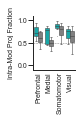

In [131]:
pltdat = dat[dat['consolidated_layer'].isin(['2/3', '5'])]
fig, ax = plt.subplots(1, figsize = (0.75, 1))
sns.boxplot('Exp Module', 'module_proj_frac', data = pltdat, 
            order = ['PFC', 'Medial', 'Somatomotor', 'Visual'], ax = ax, 
            hue = 'consolidated_layer', hue_order = ['2/3', '5'],
            palette = ['c', 'gray'], fliersize = 0.1, linewidth = 0.5)
ax.axhline(y = 0.5, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.set_ylim([-0.1,1.1])
ax.set_yticks([0, 0.5, 1])
ax.set_xticklabels(['Prefrontal', 'Medial', 'Somatomotor', 'Visual'])
sns.despine()
plt.yticks(fontsize = 7)
plt.xticks(rotation = 90, fontsize = 7)
ax.set_xlabel("")
ax.set_ylabel("Intra-Mod Proj Fraction", fontsize = 7)
ax.tick_params(top = False, right = False, bottom = False, left = True)
ax.tick_params('y', pad=1)
ax.tick_params('x', pad=-3)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_module_proj_fraction_by_layer_boxplot_horizontal.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [132]:
pltdat.rename(columns = {'Exp Module': 'module'}, inplace = True)
formula = 'module_proj_frac~C(layer)*C(module)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=1)

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [133]:
aov_table.round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(layer),1.0,0.1855,0.1855,9.5936,0.0025
C(module),5.0,1.0171,0.2034,10.5196,0.0000
C(layer):C(module),5.0,0.1269,0.0254,1.3129,0.2638
Residual,110.0,2.1271,0.0193,NaN,NaN


In [134]:
for module in pltdat['module'].unique():
    if module != 'Lateral': #not enough points
        print(module)
        mc = MultiComparison(pltdat[pltdat['module'] == module]['module_proj_frac'], 
                         pltdat[pltdat['module'] == module]['layer'])
        mc_results = mc.tukeyhsd()
        print(mc_results)

PFC
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     5    -0.1416  0.0345 -0.2716 -0.0117  True 
----------------------------------------------------
Somatomotor
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     5    -0.0995  0.0433 -0.1958 -0.0032  True 
----------------------------------------------------
Auditory
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 2/3     5     0.0928  0.4847 -0.2786 0.4641 False 
---------------------------------------------------
Medial
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     5    -0.19

## Ipsilateral vs contralateral projections

In [135]:
ipsi_dat = pd.read_csv(os.path.join(basepath, 'data_files',
                                   'wt_cre_matched_layer_injections_DMN_and_core_projections_coefficients_ipsi.csv'))
ipsi_dat = ipsi_dat[ipsi_dat['id'].isin(dat['image_series_id'])]
ipsi_dat.rename(columns = {'id': 'image_series_id',
                          'DMN coefficient': 'dmn_coeff_ipsi',
                          'projection dmn fraction': 'dmn_proj_frac_ipsi',
                          'distance coefficient': 'distance_coeff_ipsi'}, inplace=True)
print(len(ipsi_dat))

350


dat.drop(columns = {'dmn_coeff_ipsi', 'dmn_proj_frac_ipsi'},
        inplace = True)

In [136]:
print(ipsi_dat['dmn_coeff_ipsi'].min())
print(ipsi_dat['dmn_coeff_ipsi'].max())

-0.6106876505495265
0.5011403399397816


In [137]:
dat = dat.merge(ipsi_dat[['image_series_id', 'dmn_coeff_ipsi', 'distance_coeff_ipsi',
                          'dmn_proj_frac_ipsi']], 
               on = 'image_series_id', how = 'left')

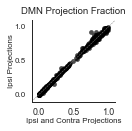

In [138]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.scatterplot('proj_dmn_frac', 'dmn_proj_frac_ipsi', data = dat,
               color = 'k', linewidth = 0, alpha = 0.7)
ax.set_ylabel('Ipsi Projections', fontsize = 8)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Ipsi and Contra Projections', fontsize = 8)
ax.set_title('DMN Projection Fraction')
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
#plt.xticks([0, 50, 100], fontsize = 8)
plt.yticks([0, 0.5, 1], fontsize = 8)
x = [-0.1, 1.1]
y = [-0.1, 1.1]
ax.plot(x,y, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'ipsi_proj_frac.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

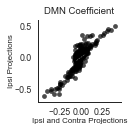

In [139]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.scatterplot('dmn_coeff', 'dmn_coeff_ipsi', data = dat,
                              color = 'k', linewidth = 0, alpha = 0.7)
ax.set_ylabel('Ipsi Projections', fontsize = 8)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Ipsi and Contra Projections', fontsize = 8)
ax.set_title('DMN Coefficient')
x = [-0.05, 0.05]
y = [-0.05, 0.05]
ax.plot(x,y, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'ipsi_dmn_coeff.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

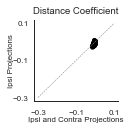

In [140]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.scatterplot('distance coefficient', 'distance_coeff_ipsi', data = dat,
                              color = 'k', linewidth = 0, alpha = 0.7)
ax.set_ylabel('Ipsi Projections', fontsize = 8)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Ipsi and Contra Projections', fontsize = 8)
ax.set_title('Distance Coefficient')
#ax.set_xlim([-7, 7])
#ax.set_ylim([-7, 7])
plt.xticks([-0.3, -0.1, 0.1], fontsize = 8)
plt.yticks([-0.3, -0.1, 0.1], fontsize = 8)
x = [-0.3, 0.1]
y = [-0.3, 0.1]
ax.plot(x,y, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False)
ax.yaxis.labelpad = -1
ax.tick_params('y', pad=1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'ipsi_distance_coeff.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [141]:
layer_plot_order

['all', '5', '2/3', '6', '5 PT', '4']

In [142]:
dat['layer'].unique()

array(['all', '5', '2/3', '5 PT', '4', '6'], dtype=object)

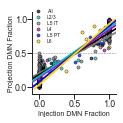

In [190]:
layer_plot_order = ['6', '5 PT', '2/3', '4', 'all', '5']
layer_colors = ['gold', 'b', 'c', 'm', 'k', 'gray']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(layer_plot_order):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='dmn_proj_frac_ipsi', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                  'linewidth':0.5,
                                  'edgecolor':'k'})
ax.set_ylabel('Projection DMN Fraction', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
#plt.xticks([0, 50, 100], fontsize = 8)
#plt.yticks([0, 50, 100], fontsize = 8)
ax.axhline(y = 0.5, xmin=-0.1, xmax=1.1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['L6', 'L5 PT', 'L2/3', 'L4', 'All', 'L5 IT']
order = [4,2,5,3,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc = 2, fontsize = 5, frameon = False,
          bbox_to_anchor = [-0.05, 1.1], labelspacing = 0.2)
plt.setp(legend.get_title(),fontsize=7)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'ipsi_DMN_proj_frac_by_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

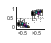

In [144]:
layer_plot_order = ['all', '5', '2/3', '4', '5 PT', '6']
layer_colors = ['k', 'gray', 'c', 'm', 'b', 'gold']
fig, ax = plt.subplots(figsize = (0.5,0.4))
sns.boxplot(x='dmn_by_ol', 
            y='dmn_proj_frac_ipsi', 
            order = ['out', 'in'],
                data = dat,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine()
ax.set_ylim([-0.1,1.1])
ax.set_yticks([0, 0.5, 1])
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 5)
ax.set_yticklabels([0, 0.5, 1], fontsize = 5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(bottom=False, left = False, pad=-3)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_boxplot_by_inj_frac_ipsi_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [145]:
formula = 'dmn_proj_frac_ipsi~dmn_by_ol*C(layer)' 
model = ols(formula, dat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf

In [146]:
aov_table.round(4)

,sum_sq,df,F,PR(>F)
dmn_by_ol,38.1618,1.0,2643.0190,0.0000
C(layer),0.1208,5.0,1.6734,0.1404
dmn_by_ol:C(layer),1.4302,5.0,19.8103,0.0000
Residual,4.8803,338.0,NaN,NaN


In [147]:
mc = MultiComparison(dat[(dat['dmn_by_ol'] == 'in')]['dmn_proj_frac_ipsi'], 
                     dat[(dat['dmn_by_ol'] == 'in')]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     4    -0.0266   0.9   -0.1541  0.1009 False 
 2/3     5    -0.1255  0.0129 -0.2337 -0.0173  True 
 2/3    5 PT   0.023    0.9   -0.0784  0.1243 False 
 2/3     6     0.0555  0.6723  -0.055  0.1661 False 
 2/3    all   -0.0785  0.448  -0.2018  0.0449 False 
  4      5    -0.0989  0.1669 -0.2184  0.0206 False 
  4     5 PT   0.0496  0.7791 -0.0637  0.1629 False 
  4      6     0.0821  0.3781 -0.0395  0.2038 False 
  4     all   -0.0519  0.8593 -0.1852  0.0815 False 
  5     5 PT   0.1485  0.001   0.0575  0.2395  True 
  5      6     0.181   0.001   0.0798  0.2822  True 
  5     all    0.047   0.8267  -0.068  0.162  False 
 5 PT    6     0.0325   0.9   -0.0613  0.1264 False 
 5 PT   all   -0.1015  0.0821 -0.2101  0.0071 False 
  6     all    -0.134  0.0151 -0.2513 -0.0167  True 
----------------------------------------------

In [148]:
mc = MultiComparison(dat[(dat['dmn_by_ol'] == 'out')]['dmn_proj_frac_ipsi'], 
                     dat[(dat['dmn_by_ol'] == 'out')]['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     4    -0.0528  0.4927 -0.1392  0.0335 False 
 2/3     5     0.0047   0.9   -0.0731  0.0825 False 
 2/3    5 PT  -0.1249  0.001  -0.2048 -0.0451  True 
 2/3     6     -0.17   0.001  -0.2526 -0.0875  True 
 2/3    all   -0.0111   0.9   -0.1009  0.0787 False 
  4      5     0.0576  0.2368 -0.0173  0.1325 False 
  4     5 PT  -0.0721  0.0816 -0.1491  0.005  False 
  4      6    -0.1172  0.001  -0.1971 -0.0373  True 
  4     all    0.0417  0.7143 -0.0456  0.1291 False 
  5     5 PT  -0.1296  0.001   -0.197 -0.0623  True 
  5      6    -0.1748  0.001  -0.2453 -0.1042  True 
  5     all   -0.0158   0.9   -0.0947  0.063  False 
 5 PT    6    -0.0451  0.4785 -0.1179  0.0277 False 
 5 PT   all    0.1138  0.001   0.0329  0.1947  True 
  6     all    0.1589  0.001   0.0753  0.2425  True 
----------------------------------------------

In [149]:
dat['dmn_coeff_ipsi'].min()

-0.6106876505495265

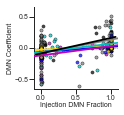

In [191]:
layer_plot_order = ['all', '2/3', '4', '5', '5 PT', '6']
layer_colors = ['k', 'c', 'm', 'gray', 'b', 'gold']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(layer_plot_order):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='dmn_coeff_ipsi', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                  'linewidth':0.5,
                                  'edgecolor':'k'})
ax.set_ylabel('DMN Coefficient', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.65, 0.65])
plt.yticks([-0.5, 0, 0.5], fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
#ax.set_title('Ipsi')
#plt.yticks([0, 50, 100], fontsize = 8)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'ipsi_DMN_coeff_by_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [151]:
stats.f_oneway(dat[dat['layer'] == '6']['dmn_coeff_ipsi'],
               dat[dat['layer'] == '2/3']['dmn_coeff_ipsi'],
               dat[dat['layer'] == '4']['dmn_coeff_ipsi'],
               dat[dat['layer'] == '5']['dmn_coeff_ipsi'],
               dat[dat['layer'] == 'all']['dmn_coeff_ipsi'],
               dat[dat['layer'] == '5 PT']['dmn_coeff_ipsi'])

F_onewayResult(statistic=1.492445350624586, pvalue=0.19159151199101537)

In [152]:
print(dat['distance_coeff_ipsi'].min())
print(dat['distance_coeff_ipsi'].max())

-0.02703230604244651
0.009151184327772085


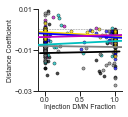

In [192]:
layer_plot_order = ['all', '2/3', '4', '5', '5 PT', '6']
layer_colors = ['k', 'c', 'm', 'gray', 'b', 'gold']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
zorder = 7
for ix, layer in enumerate(layer_plot_order):
    zorder -= 1
    ax1 = sns.regplot(x='inj_dmn_frac', 
                      y='distance_coeff_ipsi', 
                      data = dat[dat['layer'] == layer],
                      ax = ax,
                      label = layer,
                      color = layer_colors[ix],
                      ci = None,
                      line_kws = {'zorder': zorder},
                      scatter_kws={'s':10,
                                  'alpha': 0.7,
                                  'linewidth':0.5,
                                  'edgecolor':'k'})
ax.set_ylabel('Distance Coefficient', fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.03, 0.01])
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([-0.03, -0.01, 0.01], fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
#plt.yticks([0, 50, 100], fontsize = 8)
#ax.set_title('Ipsi')
ax.axhline(y = 0, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
sns.despine()
ax.tick_params(top = False, right = False, left = True, bottom = True, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)
plt.savefig(os.path.join(savepath, 'ipsi_distance_coeff_by_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [154]:
pltdat = dat[['dmn_by_ol', 'layer', 'dmn_coeff_ipsi']].melt(id_vars = ['dmn_by_ol', 'layer'],
                                                       value_vars = 'dmn_coeff_ipsi',
                                                      var_name = 'coefficient')
pltdat2 = dat[['dmn_by_ol', 'layer', 'distance_coeff_ipsi']].melt(id_vars = 
                                                                   ['dmn_by_ol', 'layer'],
                                                     value_vars = 'distance_coeff_ipsi',
                                                     var_name = 'coefficient')
#pltdat2['dmn_by_ol'] = 'both'

In [155]:
formula = 'value~C(layer)*dmn_by_ol' 
model = ols(formula, pltdat2).fit()
aov_table = anova_lm(model, typ=3)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
Intercept,0.0009,1.0,36.9111,0.0000
C(layer),0.0013,5.0,11.1482,0.0000
dmn_by_ol,0.0000,1.0,0.1462,0.7025
C(layer):dmn_by_ol,0.0001,5.0,0.7446,0.5906
Residual,0.0080,338.0,NaN,NaN


In [156]:
formula = 'value~C(layer)' 
model = ols(formula, pltdat2).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(layer),0.0034,5.0,28.7904,0.0
Residual,0.0081,344.0,NaN,NaN


In [157]:
mc = MultiComparison(pltdat2['value'], 
                     pltdat2['layer'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 2/3     4     0.0032  0.0236  0.0003  0.0062  True 
 2/3     5    -0.0017  0.4167 -0.0043  0.0009 False 
 2/3    5 PT   0.0036  0.001   0.0011  0.0062  True 
 2/3     6     0.0044  0.001   0.0017  0.0071  True 
 2/3    all   -0.0047  0.001  -0.0077 -0.0017  True 
  4      5    -0.0049  0.001  -0.0076 -0.0023  True 
  4     5 PT   0.0004   0.9   -0.0022  0.003  False 
  4      6     0.0012  0.8095 -0.0016  0.0039 False 
  4     all   -0.0079  0.001  -0.0109 -0.0049  True 
  5     5 PT   0.0053  0.001   0.0031  0.0075  True 
  5      6     0.0061  0.001   0.0037  0.0085  True 
  5     all    -0.003  0.022  -0.0057 -0.0003  True 
 5 PT    6     0.0008   0.9   -0.0016  0.0031 False 
 5 PT   all   -0.0083  0.001  -0.0109 -0.0056  True 
  6     all   -0.0091  0.001  -0.0119 -0.0062  True 
----------------------------------------------

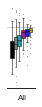

In [158]:
layer_plot_order = ['all', '5', '2/3', '4', '5 PT', '6']
layer_colors = ['k', 'gray',  'c', 'm', 'b', 'gold']
pltdat2['dmn_by_ol'] = 'both'
fig, ax = plt.subplots(figsize = (0.5,1.5))
sns.boxplot(x='dmn_by_ol', 
                y='value', 
            order = ['both'],
                data = pltdat2,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine(left = True)
ax.set_ylim([-0.03, 0.01])
plt.yticks([-0.03, -0.01, 0.01], fontsize = 8)
ax.set_xticklabels(['All'], fontsize = 8)
ax.set_yticklabels([None])
ax.set_xlabel("", fontsize = 8)
ax.set_ylabel("")
ax.tick_params(left = False, pad=1)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'distance_coeff_ipsi_boxplot_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [159]:
pltdat['value'].max()

0.5011403399397816

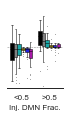

In [160]:
layer_plot_order = ['all', '5', '2/3', '6', '5 PT', '4']
layer_colors = [ 'k', 'gray',  'c', 'gold', 'b','m']
fig, ax = plt.subplots(figsize = (1,1.5))
sns.boxplot(x='dmn_by_ol', 
                y='value', 
            order = ['out', 'in'],
                data = pltdat,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine(left = True)
ax.set_ylim([-0.65, 0.65])
plt.yticks([-0.5, 0, 0.5], fontsize = 8)
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 8)
ax.set_yticklabels([None])
ax.set_xlabel("Inj. DMN Frac.", fontsize = 8)
ax.set_ylabel("")
ax.tick_params(left = False, pad=1)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_coeff_ipsi_boxplot_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

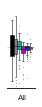

In [161]:
formula = 'value~dmn_by_ol+C(layer)' 
layer_plot_order = ['all', '5', '2/3', '4', '5 PT', '6']
layer_colors = ['k', 'gray',  'c', 'm', 'b', 'gold']
pltdat['dmn_by_ol'] = 'both'
fig, ax = plt.subplots(figsize = (0.5,1.5))
sns.boxplot(x='dmn_by_ol', 
                y='value', 
            order = ['both'],
                data = pltdat,
                 hue = 'layer',
                 hue_order = layer_plot_order,
                 palette = layer_colors,
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine(left = True)
ax.set_ylim([-0.65, 0.65])
plt.yticks([-0.5, 0, 0.5], fontsize = 8)
ax.set_xticklabels(['All'], fontsize = 8)
ax.set_yticklabels([None])
ax.set_xlabel("", fontsize = 8)
ax.set_ylabel("")
ax.tick_params(left = False, pad=1)
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_coeff_ipsi_boxplot_all_layers.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [162]:
formula = 'value~C(layer)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=3)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
Intercept,0.0004,1.0,0.0140,0.9060
C(layer),0.1907,5.0,1.4924,0.1916
Residual,8.7927,344.0,NaN,NaN


In [163]:
dat[(dat['dmn_by_structure'] == 'in') &
    (dat['layer'] == '2/3')]['proj_dmn_frac'].median()

0.9067915787933425

In [164]:
dat[(dat['dmn_by_structure'] == 'in') &
    (dat['layer'] == '5')]['proj_dmn_frac'].median()

0.7314230938078603

In [165]:
dat['Mouse Line'].unique()

array(['C57BL/6J / Emx1', 'Rbp4-Cre_KL100', 'Cux2-IRES-Cre',
       'Efr3a-Cre_NO108', 'A930038C07Rik-Tg1-Cre', 'Sim1-Cre_KJ18',
       'Scnn1a-Tg3-Cre', 'Syt6-Cre_KI148', 'Chrna2-Cre_OE25',
       'Ntsr1-Cre_GN220', 'Rorb-IRES2-Cre', 'Tlx3-Cre_PL56', 'Nr5a1-Cre',
       'Sepw1-Cre_NP39'], dtype=object)

In [166]:
print(len(dat[dat['Mouse Line'] == 'C57BL/6J / Emx1']))

41


In [167]:
print(len(dat[dat['Mouse Line'].isin(['Sepw1-Cre_NP39', 'Cux2-IRES-Cre'])]))

46


In [168]:
print(len(dat[dat['Mouse Line'].isin(['Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])]))

76
